# Building a Neural Network from Scratch!
In this notebook I build a deep learning network without any high level framework, instead relying on just Python, Numpy and Maths!

The dataset I will use is the MINST digit recognition images availiable from Kaggle at: https://www.kaggle.com/c/digit-recognizer/overview

## Setup

In [ ]:
!pip install kaggle

You'll need to upload your Kaggle API token to your Colab environment to download the dataset for this demo.

This token can be downloaded from your Kaggle account settings (Account tab, under the API section, you can create a new API token).

Then run this cell to download a kaggle.json file containing your credentials.

In [ ]:
# You need to run this cell and upload your API key (downloaded from Kaggle)
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c digit-recognizer

 33% 5.00M/15.3M [00:00<00:00, 40.0MB/s]
100% 15.3M/15.3M [00:00<00:00, 95.4MB/s]


In [ ]:
# Check it has been downloaded - your current directory should contain 'digit-recognizer.zip'
!pwd
!ls

/content
digit-recognizer.zip  kaggle.json  sample_data


In [ ]:
# Extract the dataset
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# Check the contents again - you should see 'sample_data	sample_submission.csv  test.csv  train.csv'
!ls

digit-recognizer.zip  kaggle.json  sample_data	sample_submission.csv  test.csv  train.csv


Note: For faster training it is recommended you setup Google Colab to run on a GPU or TPU instead of a CPU. Go to Runtime > Change runtime type > Hardware Accelerator > Select 'T4 GPU' (or equivalent).

## Python Environment

In [ ]:
# Nice and simple as we're building everything from scratch!
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt # Used to plot training metrics and images for evaluation

## Import and manipulate data

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head() # Each row corresponds to a training sample

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Convert to np array
data = np.array(data)

# Extract number of rows (m) and columns (n)
m, n = data.shape
print("rows (m) =", m)
print("columns (n) =", n)

# Shuffle rows in dataset
np.random.shuffle(data)

# Split training and test sets
data_test = data[0:1000].T  # Extract first 1000 rows and transpose
Y_test = data_test[0]  # Extract labels from first row (originally the first column)
X_test = data_test[1:n] / 255.0  # Extract remaining rows and normalize pixel values

data_train = data[1000:m].T  # Extract remaining rows and transpose
Y_train = data_train[0]  # Extract labels from first row (originally the first column)
X_train = data_train[1:n] / 255.0  # Extract remaining rows and normalize pixel values

rows (m) = 42000
columns (n) = 785


In [ ]:
# Verify shapes of training and test sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (784, 41000)
Y_train shape: (41000,)
X_test shape: (784, 1000)
Y_test shape: (1000,)


## The Neural Network!

**Overview of the Neural Network Structure**

There are 3 layers:
- **Input Layer:** The network takes an input vector representing the flattened 28x28 pixel values of an image (784 features in total).
- **Hidden Layer:** The network has one hidden layer with 10 neurons. Each neuron applies a linear transformation followed by a ReLU activation function.
- **Output Layer:** The network has an output layer with 10 neurons, corresponding to the 10 classes of digits (0-9). Each neuron in this layer applies a linear transformation followed by a softmax activation function to output probabilities.

**Summary of code**

The functions below are required for:

1. ***Initialisation:***

 - **init_params():** Initializes weights and biases for the network layers.
W1 and b1 for the first layer, and W2 and b2 for the second layer are randomly initialised.

2. ***Activations:***

 - **ReLU(Z):** Implements the Rectified Linear Unit (ReLU) activation function, which returns the input Z with all negative values set to zero.
 - **softmax(Z):** Implements the softmax activation function, which converts the input Z into probabilities by exponentiating and normalizing by the sum of exponentials.

3. ***Forward Propagation:***

 - **forward_prop(W1, b1, W2, b2, X):** Computes the activations for each layer.
Z1 is the linear combination of inputs and weights for the first layer plus bias.
A1 is the activation from the first layer after applying ReLU.
Z2 is the linear combination of activations from the first layer and weights for the second layer plus bias.
A2 is the activation from the second layer after applying softmax.

4. ***Derivative of ReLU:***

 - **ReLU_deriv(Z):** Implements the derivative of the ReLU function, returning a binary array where each element is 1 if the corresponding element in Z is positive and 0 otherwise.

5. ***One-hot Encoding:***

 - **one_hot(Y):** Converts labels into one-hot encoded vectors. Each label is represented as a vector with 1 at the index corresponding to the label and 0 elsewhere.

6. ***Backward Propagation:***

 - **backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):** Computes the gradients of the loss with respect to weights and biases.
one_hot_Y converts Y into one-hot encoded format.
dZ2 is the gradient of the loss with respect to Z2.
dW2 is the gradient of the loss with respect to W2.
db2 is the gradient of the loss with respect to b2.
dZ1 is the gradient of the loss with respect to Z1.
dW1 is the gradient of the loss with respect to W1.
db1 is the gradient of the loss with respect to b1.

7. ***Parameter Updates:***

 - **update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):** Updates the parameters using the computed gradients and the learning rate alpha.
W1, b1, W2, b2 are updated by subtracting the gradients scaled by the learning rate.

In [ ]:
class NeuralNetworkTraining:
    """
    A class used to train a neural network and plot training metrics.

    Attributes
    ----------
    accuracy_history : list
        A list to store the accuracy values at different iterations.
    loss_history : list
        A list to store the loss values at different iterations.
    weight_history : list
        A list to store the weight matrices at different iterations.
    bias_history : list
        A list to store the bias vectors at different iterations.
    """

    def __init__(self):
        """
        Initializes the NeuralNetworkTraining class with empty history lists.
        """
        self.accuracy_history = []
        self.loss_history = []
        self.weight_history = []
        self.bias_history = []

    @staticmethod
    def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
        """
        Updates the parameters of the neural network using gradient descent.

        Args:
            W1, b1, W2, b2: Current weights and biases.
            dW1, db1, dW2, db2: Gradients of weights and biases.
            alpha: Learning rate.

        Returns:
            Updated weights and biases.
        """
        W1 -= alpha * dW1
        b1 -= alpha * db1
        W2 -= alpha * dW2
        b2 -= alpha * db2
        return W1, b1, W2, b2

    @staticmethod
    def get_predictions(A2):
        """
        Gets the predictions from the output of the neural network.

        Args:
            A2: Output array from the final layer.

        Returns:
            Array of predictions.
        """
        return np.argmax(A2, axis=0)

    @staticmethod
    def get_accuracy(predictions, Y):
        """
        Calculates the accuracy of the predictions.

        Args:
            predictions: Array of predicted labels.
            Y: Array of true labels.

        Returns:
            Accuracy as a float.
        """
        return np.sum(predictions == Y) / Y.size

    def gradient_descent(self, X, Y, alpha=0.1, iterations=500):
        """
        Performs gradient descent to optimize the weights and biases of the neural network.

        Args:
            X: Input data.
            Y: True labels.
            alpha: Learning rate.
            iterations: Number of iterations for the training loop.

        Returns:
            Final optimized weights and biases.
        """
        W1, b1, W2, b2 = NeuralNetworkUtils.init_params()
        for i in range(iterations):
            Z1, A1, Z2, A2 = NeuralNetworkPropagation.forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = NeuralNetworkPropagation.back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = NeuralNetworkTraining.update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

            if i % 10 == 0 or i == iterations - 1:
                predictions = NeuralNetworkTraining.get_predictions(A2)
                accuracy = NeuralNetworkTraining.get_accuracy(predictions, Y)
                loss = -np.mean(np.log(A2[Y, np.arange(Y.size)]))

                self.accuracy_history.append(accuracy)
                self.loss_history.append(loss)
                self.weight_history.append((W1.copy(), W2.copy()))
                self.bias_history.append((b1.copy(), b2.copy()))

                print(f"Iteration {i}: Accuracy = {accuracy * 100:.2f}%, Loss = {loss:.4f}")

        # Print final iteration details
        predictions = NeuralNetworkTraining.get_predictions(A2)
        accuracy = NeuralNetworkTraining.get_accuracy(predictions, Y)
        loss = -np.mean(np.log(A2[Y, np.arange(Y.size)]))

        print(f"Final Iteration {iterations}: Accuracy = {accuracy * 100:.2f}%, Loss = {loss:.4f}")

        return W1, b1, W2, b2

    def plot_metrics(self):
        """
        Plots the accuracy and loss over iterations.
        """
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.accuracy_history, label='Accuracy')
        plt.xlabel('Iterations (per 10)')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Iterations (per 10)')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_weights(self):
        """
        Plots the values of weights over iterations.
        """
        epochs = [i * 10 for i in range(len(self.weight_history))]

        plt.figure(figsize=(12, 6))
        for i in range(self.weight_history[0][0].shape[0]):  # Number of rows in W1
            for j in range(self.weight_history[0][0].shape[1]):  # Number of columns in W1
                w1_values = [w1[i, j] for w1, _ in self.weight_history]
                plt.plot(epochs, w1_values, label=f'W1[{i},{j}]' if i == 0 and j == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Weight Value')
        plt.title('Weights W1 (layer 1) over Time')
        plt.show()

        plt.figure(figsize=(12, 6))
        for i in range(self.weight_history[0][1].shape[0]):  # Number of rows in W2
            for j in range(self.weight_history[0][1].shape[1]):  # Number of columns in W2
                w2_values = [w2[i, j] for _, w2 in self.weight_history]
                plt.plot(epochs, w2_values, label=f'W2[{i},{j}]' if i == 0 and j == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Weight Value')
        plt.title('Weights W2 (layer 2) over Time')
        plt.show()

    def plot_biases(self):
        """
        Plots the values of biases over iterations.
        """
        epochs = [i * 10 for i in range(len(self.bias_history))]

        plt.figure(figsize=(12, 6))
        for i in range(self.bias_history[0][0].shape[0]):  # Number of elements in b1
            b1_values = [b1[i, 0] for b1, _ in self.bias_history]
            plt.plot(epochs, b1_values, label=f'b1[{i}]' if i == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Bias Value')
        plt.title('Biases b1 (layer 1) over Time')
        plt.show()

        plt.figure(figsize=(12, 6))
        for i in range(self.bias_history[0][1].shape[0]):  # Number of elements in b2
            b2_values = [b2[i, 0] for _, b2 in self.bias_history]
            plt.plot(epochs, b2_values, label=f'b2[{i}]' if i == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Bias Value')
        plt.title('Biases b2 (layer 2) over Time')
        plt.show()


# Training Setup

**Summary of code**

Functions required for training are as follows:

1. ***Parameter Updates:***

 - **update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):** Updates the parameters using the computed gradients and the learning rate alpha.
W1, b1, W2, b2 are updated by subtracting the gradients scaled by the learning rate.

2. ***Predictions:***

 - **get_predictions(A2):** Returns the index of the maximum value in each column of A2, which corresponds to the predicted class.

3. ***Accuracy Calculation:***

 - **get_accuracy(predictions, Y):** Computes the accuracy of the predictions by comparing them to the true labels Y.

4. ***Gradient Descent:***
 - **gradient_descent(X, Y, alpha, iterations):** Trains the neural network using gradient descent. Initializes parameters using init_params(). For a specified number of iterations, performs forward propagation using forward_prop(), computes gradients using backward_prop(), updates parameters using update_params(), and periodically prints the accuracy.

In [ ]:
class NeuralNetworkTraining:
    """
    A class used to train a neural network and plot training metrics.

    Attributes
    ----------
    accuracy_history : list
        A list to store the accuracy values at different iterations.
    loss_history : list
        A list to store the loss values at different iterations.
    weight_history : list
        A list to store the weight matrices at different iterations.
    bias_history : list
        A list to store the bias vectors at different iterations.
    """

    def __init__(self):
        """
        Initializes the NeuralNetworkTraining class with empty history lists.
        """
        self.accuracy_history = []
        self.loss_history = []
        self.weight_history = []
        self.bias_history = []

    @staticmethod
    def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
        """
        Updates the parameters of the neural network using gradient descent.

        Args:
            W1, b1, W2, b2: Current weights and biases.
            dW1, db1, dW2, db2: Gradients of weights and biases.
            alpha: Learning rate.

        Returns:
            Updated weights and biases.
        """
        W1 -= alpha * dW1
        b1 -= alpha * db1
        W2 -= alpha * dW2
        b2 -= alpha * db2
        return W1, b1, W2, b2

    @staticmethod
    def get_predictions(A2):
        """
        Gets the predictions from the output of the neural network.

        Args:
            A2: Output array from the final layer.

        Returns:
            Array of predictions.
        """
        return np.argmax(A2, axis=0)

    @staticmethod
    def get_accuracy(predictions, Y):
        """
        Calculates the accuracy of the predictions.

        Args:
            predictions: Array of predicted labels.
            Y: Array of true labels.

        Returns:
            Accuracy as a float.
        """
        return np.sum(predictions == Y) / Y.size

    def gradient_descent(self, X, Y, alpha=0.1, iterations=500):
        """
        Performs gradient descent to optimize the weights and biases of the neural network.

        Args:
            X: Input data.
            Y: True labels.
            alpha: Learning rate.
            iterations: Number of iterations for the training loop.

        Returns:
            Final optimized weights and biases.
        """
        W1, b1, W2, b2 = NeuralNetworkUtils.init_params()
        for i in range(iterations):
            Z1, A1, Z2, A2 = NeuralNetworkPropagation.forward_prop(W1, b1, W2, b2, X)
            dW1, db1, dW2, db2 = NeuralNetworkPropagation.back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
            W1, b1, W2, b2 = NeuralNetworkTraining.update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

            if i % 10 == 0 or i == iterations - 1:
                predictions = NeuralNetworkTraining.get_predictions(A2)
                accuracy = NeuralNetworkTraining.get_accuracy(predictions, Y)
                loss = -np.mean(np.log(A2[Y, np.arange(Y.size)]))

                self.accuracy_history.append(accuracy)
                self.loss_history.append(loss)
                self.weight_history.append((W1.copy(), W2.copy()))
                self.bias_history.append((b1.copy(), b2.copy()))

                print(f"Iteration {i}: Accuracy = {accuracy * 100:.2f}%, Loss = {loss:.4f}")

        # Print final iteration details
        predictions = NeuralNetworkTraining.get_predictions(A2)
        accuracy = NeuralNetworkTraining.get_accuracy(predictions, Y)
        loss = -np.mean(np.log(A2[Y, np.arange(Y.size)]))

        print(f"Final Iteration {iterations}: Accuracy = {accuracy * 100:.2f}%, Loss = {loss:.4f}")

        return W1, b1, W2, b2

    def plot_metrics(self):
        """
        Plots the accuracy and loss over iterations.
        """
        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.accuracy_history, label='Accuracy')
        plt.xlabel('Iterations (per 10)')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(self.loss_history, label='Loss')
        plt.xlabel('Iterations (per 10)')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_weights(self):
        """
        Plots the values of weights over iterations.
        """
        epochs = [i * 10 for i in range(len(self.weight_history))]

        plt.figure(figsize=(12, 6))
        for i in range(self.weight_history[0][0].shape[0]):  # Number of rows in W1
            for j in range(self.weight_history[0][0].shape[1]):  # Number of columns in W1
                w1_values = [w1[i, j] for w1, _ in self.weight_history]
                plt.plot(epochs, w1_values, label=f'W1[{i},{j}]' if i == 0 and j == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Weight Value')
        plt.title('Weights W1 (layer 1) over Time')
        plt.show()

        plt.figure(figsize=(12, 6))
        for i in range(self.weight_history[0][1].shape[0]):  # Number of rows in W2
            for j in range(self.weight_history[0][1].shape[1]):  # Number of columns in W2
                w2_values = [w2[i, j] for _, w2 in self.weight_history]
                plt.plot(epochs, w2_values, label=f'W2[{i},{j}]' if i == 0 and j == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Weight Value')
        plt.title('Weights W2 (layer 2) over Time')
        plt.show()

    def plot_biases(self):
        """
        Plots the values of biases over iterations.
        """
        epochs = [i * 10 for i in range(len(self.bias_history))]

        plt.figure(figsize=(12, 6))
        for i in range(self.bias_history[0][0].shape[0]):  # Number of elements in b1
            b1_values = [b1[i, 0] for b1, _ in self.bias_history]
            plt.plot(epochs, b1_values, label=f'b1[{i}]' if i == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Bias Value')
        plt.title('Biases b1 (layer 1) over Time')
        plt.show()

        plt.figure(figsize=(12, 6))
        for i in range(self.bias_history[0][1].shape[0]):  # Number of elements in b2
            b2_values = [b2[i, 0] for _, b2 in self.bias_history]
            plt.plot(epochs, b2_values, label=f'b2[{i}]' if i == 0 else "", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Bias Value')
        plt.title('Biases b2 (layer 2) over Time')
        plt.show()

# Run Training!

Remember ***gradient_descent()*** takes the inputs:
- **X_train** (our training data)
- **Y_train** (our training labels)
- **alpha** (the learning rate, default = 0.1)
- **iterations** (training epoch number, default=500)

In [ ]:
# Initialize the data (assuming X_train, Y_train, X_test, and Y_test are already defined)
trainer = NeuralNetworkTraining()
W1, b1, W2, b2 = trainer.gradient_descent(X_train, Y_train, 0.1, 500)

Iteration 0: Accuracy = 10.81%, Loss = 2.3023
Iteration 10: Accuracy = 21.47%, Loss = 2.3005
Iteration 20: Accuracy = 27.06%, Loss = 2.2975
Iteration 30: Accuracy = 38.67%, Loss = 2.2914
Iteration 40: Accuracy = 49.04%, Loss = 2.2777
Iteration 50: Accuracy = 47.36%, Loss = 2.2468
Iteration 60: Accuracy = 41.71%, Loss = 2.1826
Iteration 70: Accuracy = 42.42%, Loss = 2.0709
Iteration 80: Accuracy = 48.47%, Loss = 1.9071
Iteration 90: Accuracy = 53.35%, Loss = 1.7004
Iteration 100: Accuracy = 59.79%, Loss = 1.4880
Iteration 110: Accuracy = 65.87%, Loss = 1.3047
Iteration 120: Accuracy = 69.80%, Loss = 1.1563
Iteration 130: Accuracy = 72.96%, Loss = 1.0357
Iteration 140: Accuracy = 75.82%, Loss = 0.9369
Iteration 150: Accuracy = 77.91%, Loss = 0.8559
Iteration 160: Accuracy = 79.57%, Loss = 0.7896
Iteration 170: Accuracy = 80.82%, Loss = 0.7354
Iteration 180: Accuracy = 81.80%, Loss = 0.6907
Iteration 190: Accuracy = 82.59%, Loss = 0.6536
Iteration 200: Accuracy = 83.27%, Loss = 0.6223
Ite

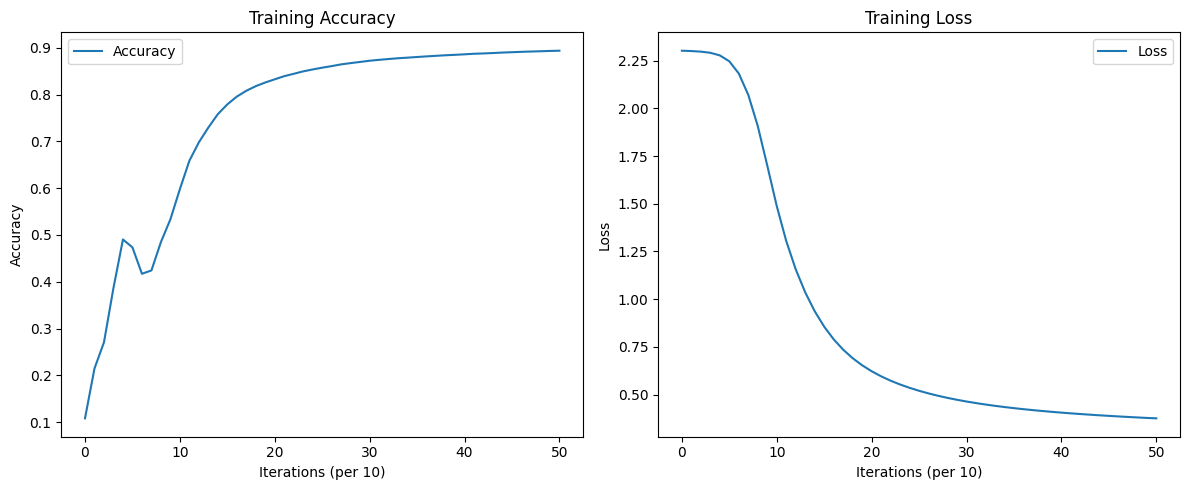

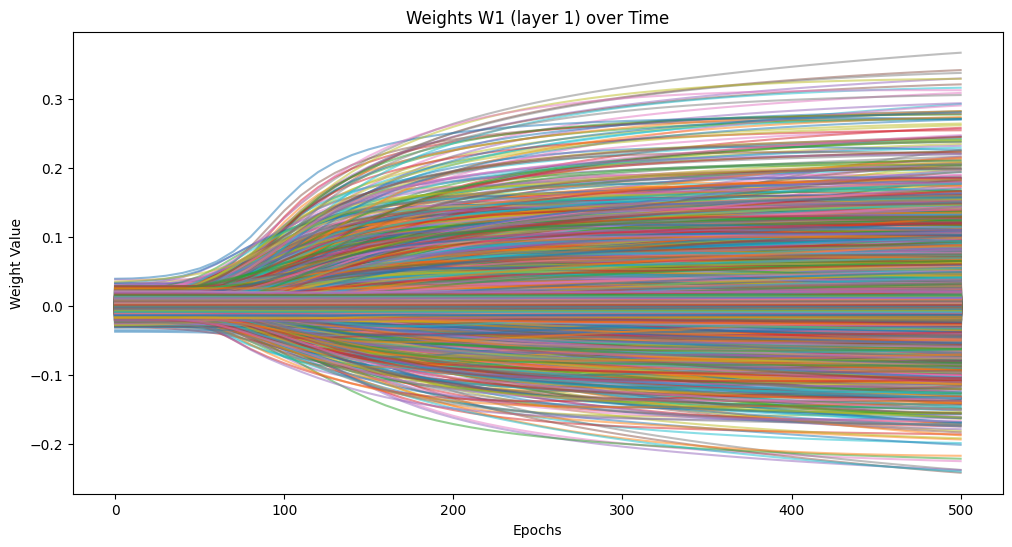

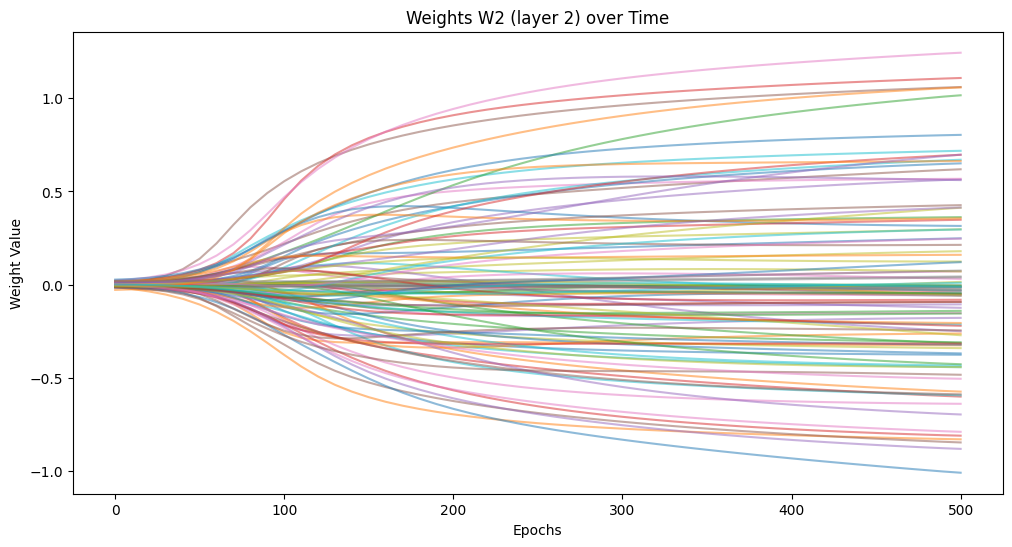

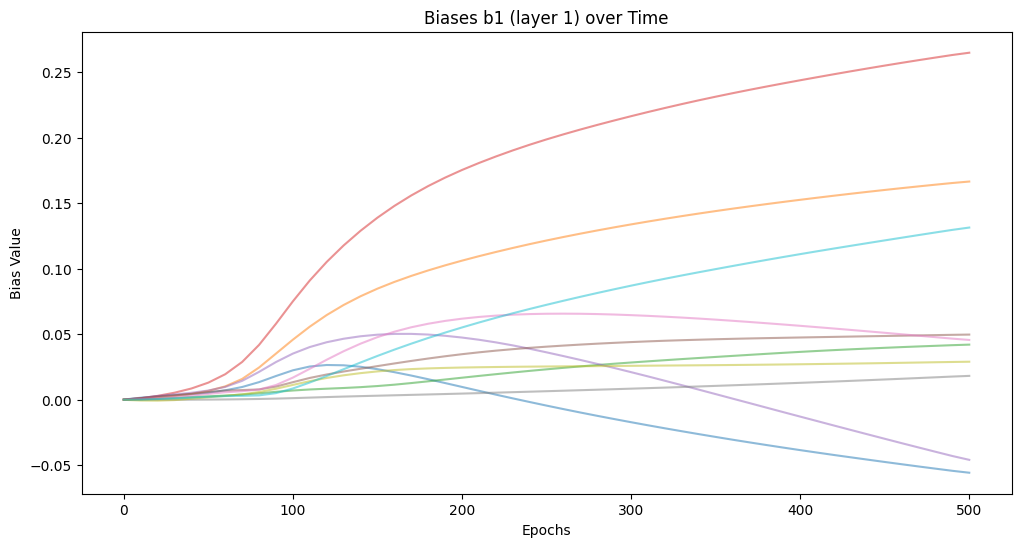

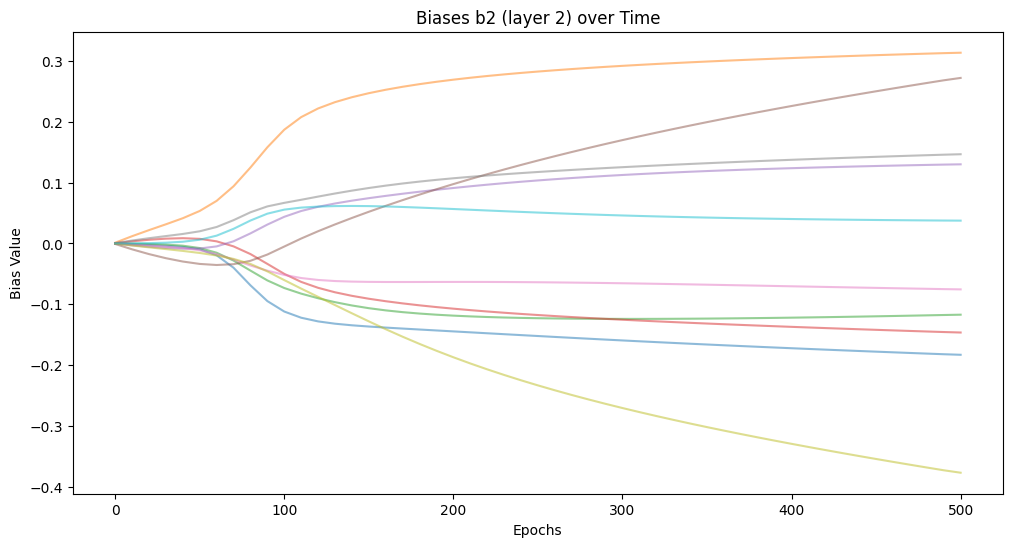

In [ ]:
# Plot the metrics
trainer.plot_metrics()

# Plot the actual values of weights over time
trainer.plot_weights()

# Plot the actual values of biases over time
trainer.plot_biases()

# Evaluation Setup

**Summary of Functions**

1. Making Predictions:

 - ***make_predictions(X, W1, b1, W2, b2):***
Purpose: Generates predictions for a given set of input data X using the trained weights and biases.
Process:
Performs forward propagation using forward_prop() to get the final layer activations A2.
Uses get_predictions(A2) to determine the predicted class for each input sample.
Returns: Array of predicted class indices.
Testing a Single Prediction:

  - ***test_prediction(index, W1, b1, W2, b2):***
Purpose: Tests and visualizes the prediction for a single sample from the training set.
Process:
Extracts the image at the specified index from X_train and reshapes it for visualization.
Makes a prediction for the selected image using make_predictions().
Prints the predicted and actual labels.
Rescales the image and displays it using matplotlib.
Visual Output: Displays the image along with the predicted and actual labels.


In [ ]:
class NeuralNetworkPrediction:
    @staticmethod
    def make_predictions(X, W1, b1, W2, b2):
        """
        Generates predictions for the given input data using the trained weights and biases.

        Args:
            X: Input data.
            W1, b1: Weights and biases for the first layer.
            W2, b2: Weights and biases for the second layer.

        Returns:
            Array of predicted class indices.
        """
        _, _, _, A2 = NeuralNetworkPropagation.forward_prop(W1, b1, W2, b2, X)
        return NeuralNetworkTraining.get_predictions(A2)

    @staticmethod
    def test_prediction(index, W1, b1, W2, b2, X_train, Y_train):
        """
        Tests and visualizes the prediction for a single sample from the training set.

        Args:
            index: Index of the sample to be tested.
            W1, b1: Weights and biases for the first layer.
            W2, b2: Weights and biases for the second layer.

        Visual Output:
            Displays the image along with the predicted and actual labels.
        """
        current_image = X_train[:, index, None]
        prediction = NeuralNetworkPrediction.make_predictions(current_image, W1, b1, W2, b2)
        label = Y_train[index]

        print("Prediction:", prediction)
        print("Label:", label)

        current_image = current_image.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()

# Run Evaluation!

Remember ***test_prediction()*** takes the inputs:
- **index** (position of the test image in the dataset X_test)
- **W1** (weights for the hidden layer)
- **b1** (biases for the hidden layer)
- **W2** (weights for the output layer)
- **b2** (biases for the output layer)

In [ ]:
# Evaluate on test set
test_predictions = NeuralNetworkPrediction.make_predictions(X_test, W1, b1, W2, b2)
accuracy = NeuralNetworkTraining.get_accuracy(test_predictions, Y_test)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Test set accuracy: 89.40%


Prediction: [5]
Label: 5


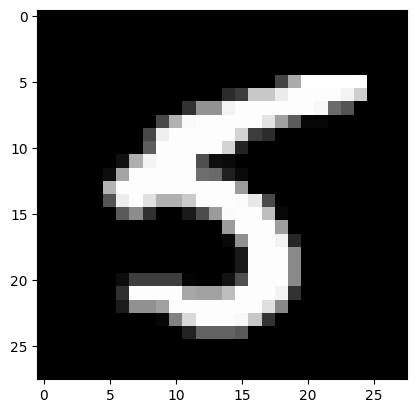

Prediction: [7]
Label: 7


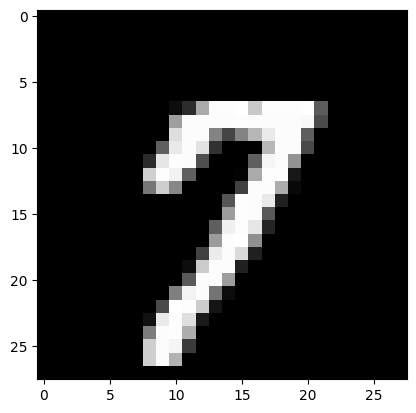

Prediction: [1]
Label: 1


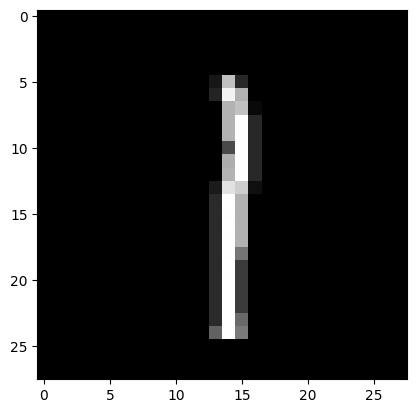

Prediction: [1]
Label: 1


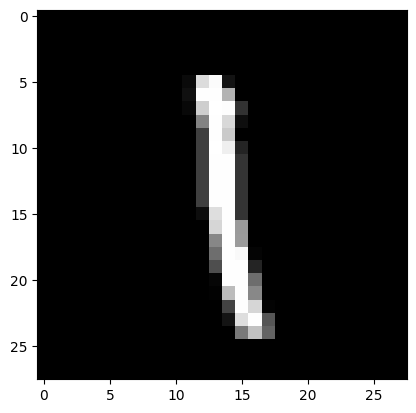

Prediction: [6]
Label: 6


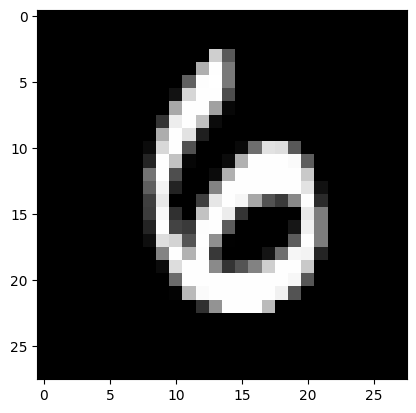

Prediction: [4]
Label: 4


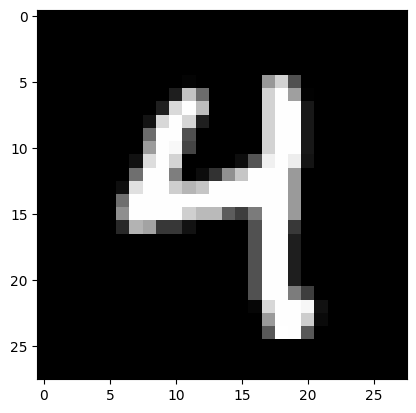

Prediction: [6]
Label: 6


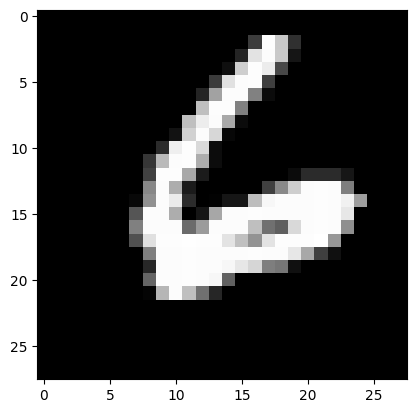

Prediction: [2]
Label: 2


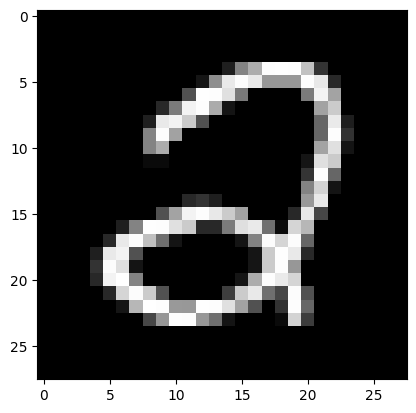

Prediction: [5]
Label: 5


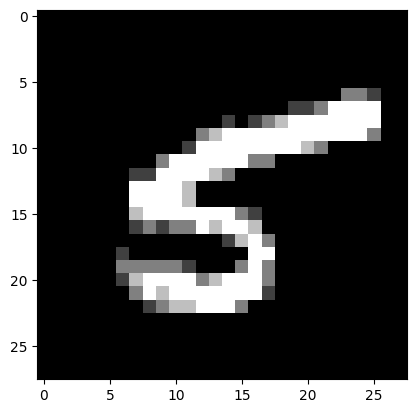

Prediction: [6]
Label: 6


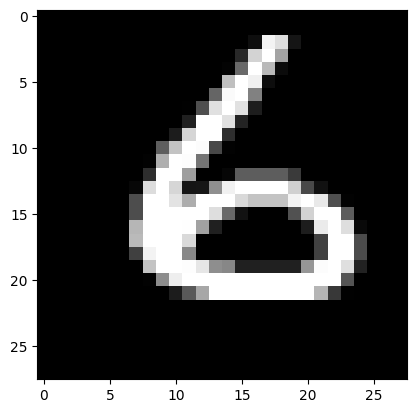

In [ ]:
# Select 10 random samples from the training set
random_indices = np.random.choice(X_train.shape[1], 10, replace=False)

# Test and visualize predictions for the selected random samples
for i in random_indices:
    NeuralNetworkPrediction.test_prediction(i, W1, b1, W2, b2, X_train, Y_train)

# C'est fini!

Hope you enjoyed this adventure into building out the maths behind Neural Nets!

Contact me via my Website or LinkedIn!

Thanks,

Ben :)